In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
torch.set_printoptions(precision=3, sci_mode=False)
np.set_printoptions(suppress=True)

In [2]:
from lib.Signature import Signature, Basepoint, sig_lreg, Cumsum2
from lib.Utilities import plot_nsde as plot, get_n_params
from lib.NSDE import SigNSDE
from lib.Training_NSDE_sigwgan import train_sigwgan

In [3]:
data = torch.load('../data/data.pt')

Let's first compute the truncated signatures, and then we will approximate the linear functional that predicts the expected signature

In [4]:
sig_X = Signature(depth=5, augmentations = [Basepoint, Cumsum2], 
                  data_size=data['X_train'].shape[2],
                  interval=[0, data['X_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['X_train'][:, :, 0].max()).to('cpu')

sig_Y = Signature(depth=4, augmentations = [Cumsum2], 
                  data_size=data['Y_train'].shape[2],
                  interval=[0, data['Y_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['Y_train'][:, :, 0].max()).to('cpu')

In [5]:
signatures_X, signatures_Y, signatures_Y_pred, sig_Y = sig_lreg(sig_X, sig_Y, data, 528, alpha=0.1, normalize_sig = True)

MSE train: 0.7678 MSE val: 1.1136 MSE test: 0.7100


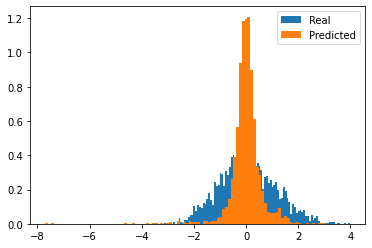

In [6]:
plt.rcParams['figure.figsize'] = [6, 4]
i = 0
a = plt.hist(signatures_Y['val'][:, i].numpy(), density = True, bins = 100, label = 'Real')
b = plt.hist(signatures_Y_pred['val'][:, i].numpy(), density = True, bins = 100, label='Predicted')
plt.legend()

We will scale the parameters of the generator to have the right size. This is done by trial and error, and will help training.

In [7]:
sig_size = sig_X(torch.zeros_like(data['X_train'][:1])).shape[1]
data_size = 1
cvector_size = 32
initial_noise_size = 16
hidden_size = 48
architectures = {'initial': [32], 'drift': [84], 'diffusion': [84]}
t_norm=None
noise_size = 8
noise_type = 'diagonal'
final_tanh = True
proj = False
translation = False

Total number of parameters:      29161


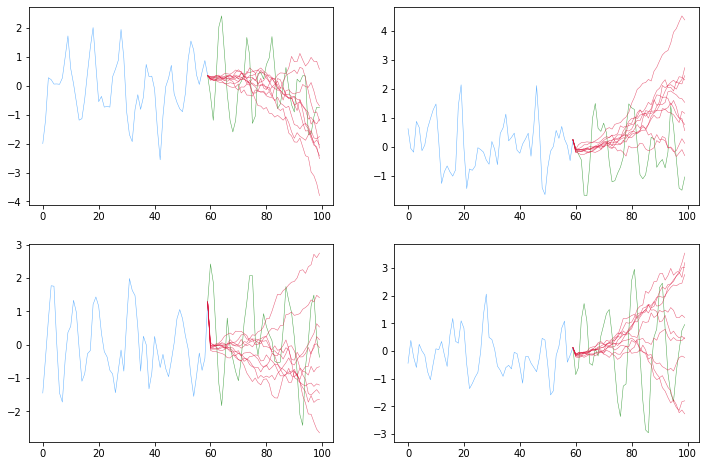

In [8]:
G = SigNSDE(sig_size, data_size, cvector_size, initial_noise_size, hidden_size, architectures, t_norm, 
            noise_size, noise_type, final_tanh, proj, translation).to(device)

print(f"Total number of parameters: {get_n_params(G):10}")

init_mult1 = 0.5
init_mult2 = 0.8
with torch.no_grad():
    for param in G._conditioned._func._drift.parameters():
        param *= init_mult1
        
    for param in G._conditioned._func._diffusion.parameters():
        param *= init_mult2
        
plot(G, data['X_train'], data['Y_train'], signatures_X['train'], 10, 1, 'cpu')

## Training

In [9]:
G_optimizer = torch.optim.Adam(G.parameters(),lr = 1e-3)

hp = {'steps_per_print': 250, 'nsamples_fs': 100, 'steps':10,
      'batch_size': 528}

In [10]:
train_dataset = TensorDataset(signatures_X['train'], data['X_train'][:, :, 1:], signatures_Y_pred['train'])
train_dataloader = DataLoader(train_dataset, hp['batch_size'], shuffle=True)

val_dataset = TensorDataset(signatures_X['val'], data['X_val'][:, :, 1:], signatures_Y_pred['val'])
val_dataloader = DataLoader(val_dataset, hp['batch_size'], shuffle=True)

test_dataset = TensorDataset(signatures_X['test'], data['X_test'][:, :, 1:], signatures_Y_pred['test'])
test_dataloader = DataLoader(test_dataset, hp['batch_size'], shuffle=True)

In [11]:
channels_sig_Y = signatures_Y_pred['train'].shape[1]
print(f"The number of elements of the signature Y is {channels_sig_Y}")

channels_sig_X = signatures_X['train'].shape[1]
print(f"The number of elements of the signature X is {channels_sig_X}")

The number of elements of the signature Y is 120
The number of elements of the signature X is 363


  0%|          | 0/10 [00:00<?, ?it/s]

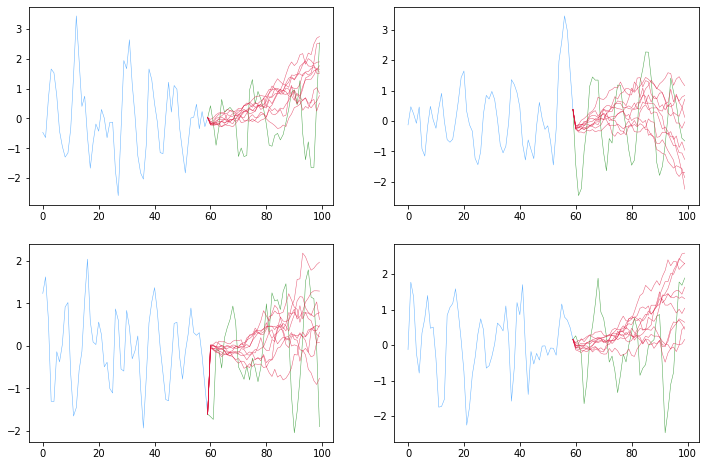

 10%|█         | 1/10 [00:02<00:23,  2.59s/it]

Step:    0 Val loss (unaveraged): 710.2596 Train_loss (unaveraged): 766.2306


 90%|█████████ | 9/10 [00:09<00:00,  1.14it/s]

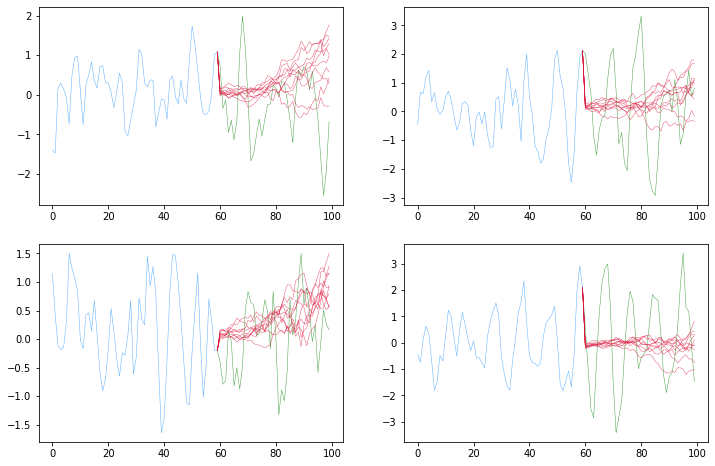

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Step:    9 Val loss (unaveraged): 39.7256 Train_loss (unaveraged): 30.5525
Best validation loss: 39.7256 Test loss: 28.7427
Total time (in hours): 0.0031 Number of steps:     9
Maximum memory allocated (in MB): 3764.2368 Total number of parameters:      29161


In [12]:
G, G_optimizer = train_sigwgan(G, sig_Y, train_dataloader, val_dataloader, test_dataloader, hp, signatures_X['train'], data['X_train'], data['Y_train'], 
                  G_optimizer, patience = 1000, epsilon = 0, max_time=3)

We load the pre-trained model.

In [13]:
save_model=False
if save_model:
    torch.save(G.state_dict(), 'G.pt')
    
load_model = True
if load_model:
    G.load_state_dict(torch.load('G.pt'))

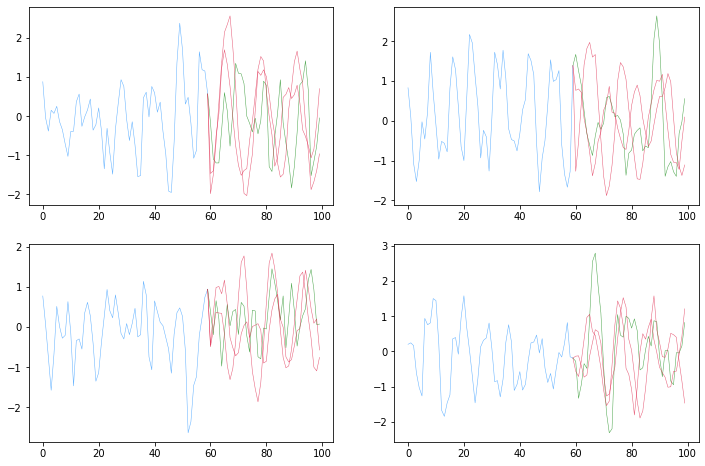

In [14]:
plot(G.to('cpu'), data['X_test'].cpu(), data['Y_test'].cpu(), signatures_X['test'], nsamples_fs=2, device='cpu')

## Metrics

Next we evaluate the model according to the different metrics described in the memory.

### Classification error

First we train a classificator that tells real from fake data.

In [15]:
from lib.Metrics import evaluate_performance, Evaluator

In [16]:
E = Evaluator(input_size = [1,1], hidden_size = [2,2], num_layers = [2,2], sep=data['X_train'].shape[1]).to(device)
data_e = data.copy()
for dataset in data_e:
    data_e[dataset] = data_e[dataset][:, :, 1:]

E_optimizer = torch.optim.Adam(E.parameters(), lr=1e-3)

hp_e = {'batch_size': 528, 'steps': 10000, 'steps_per_print': 500, 'E_optimizer': E_optimizer}

E = evaluate_performance(E, G, data_e, hp_e, sig_X = signatures_X, device='cuda', generator = 'nsde', print_=False)

Training samples:  17360  Validation samples:  3720  Test samples:  3720


100%|██████████| 10000/10000 [03:09<00:00, 52.72it/s]

AUC: 0.9793 Accuracy: 0.9035


### Extreme values metric

Next we evaluate the Extreme Values metric. The names of the function is trading_metric, with the option of specifying whether you want to predict the probability of going up (type_='buying') or down (type_'selling'), and the threshold you want to set (alpha).

In [17]:
from lib.Metrics import trading_metric, summary_statistics

In [18]:
test_pred_buying, test_real_buying = trading_metric(data['X_test'], data['Y_test'], G, 1000, 10, alpha=4.87, pct = False, 
                                                    type_='buying', generator = 'nsde', sig_X = signatures_X['test'], 
                                                        device='cuda')

test_pred_selling, test_real_selling = trading_metric(data['X_test'], data['Y_test'], G, 1000, 10, alpha=-4.87, pct = False, 
                                                      type_='selling', generator = 'nsde', sig_X = signatures_X['test'], 
                                                          device='cuda')

In [19]:
summary_statistics(test_pred_buying, test_real_buying)

The ROC AUC score is 0.9665


In [20]:
summary_statistics(test_pred_selling, test_real_selling)

The ROC AUC score is 0.9128


### Metric on marginal distribution


In [21]:
from lib.Metrics import distribution_metric

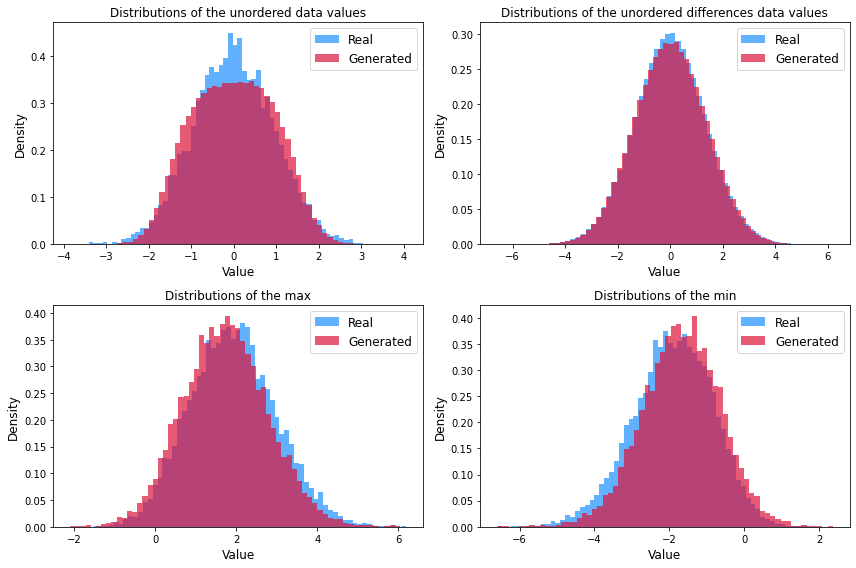

The Wasserstein-1 distance between the real and generated distributions is 0.0677
The Wasserstein-1 distance between the real and generated difference distributions is 0.0226
The Wasserstein-1 distance between the real and generated max distributions is 0.1950
The Wasserstein-1 distance between the real and generated min distributions is 0.2203


In [22]:
distribution_metric(data['X_test'][:, :, 1:].to(device), data['Y_test'][:, :, 1:].to(device), G.to(device), 
                    sig_X = signatures_X['test'].to(device), 
                    generator='nsde', log=False, inc = False, stats=None)

### Signature metric

In [23]:
from lib.Metrics import signature_metric

In [24]:
signature_metric(data, G, 6, 5, 100, 100, 'nsde',signatures_X['test'], normalize=True, device='cuda')

MSE train: 0.6474 MSE val: 0.6675 MSE test: 0.5124
The signature-wasserstein metric loss is 0.8919


### ACF function

In [25]:
from lib.Metrics import acf_metric

x = data['X_test'][:, :, 1:].cpu()
y = data['Y_test'][:, :, 1:].cpu()
G = G.cpu()

acf_real, acf_fake, acf_error = acf_metric(x, y, G, max_lag=5, generator='nsde', sig_X = signatures_X['test'])
acf_error

0.9816354320386552